In [ ]:
# build the model class

import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
from tqdm import tqdm
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

INPUT_DIM = 784
Z_DIM = 20
H1_DIM = 500
H2_DIM = 400
H3_DIM = 300
H4_DIM = 200

NUM_EPOCHS = 10
BATCH_SIZE = 32
LR_RATE = 3e-4
BETA = 1
LATENT_DIM = 20



def log_likelihood_gaussian(x, mu_z, logvar_z):
      return -0.5 * (logvar_z + (x - mu_z)**2 / logvar_z.exp()).sum(dim=-1)


# NN == 784 -> 500 -> 400 -> 300 -> 200 -> LATENT_DIM
class RecognitionModel(nn.Module):


    def __init__(self, latent_dim: int = 10):
        super(RecognitionModel, self).__init__()

        # Boilerplate NN stuff
        self.fc1 = nn.Linear(784, H1_DIM)
        self.fc2 = nn.Linear(H1_DIM, H2_DIM)
        self.fc3 = nn.Linear(H2_DIM, H3_DIM)
        self.fc4 = nn.Linear(H3_DIM, H4_DIM)

        self.fc41 = nn.Linear(H4_DIM, latent_dim)
        self.fc42 = nn.Linear(H4_DIM, latent_dim)


    def kl(self, mu_z, logvar_z):
        """Calculate KL divergence between a diagonal gaussian and a standard normal."""
        return -0.5 * torch.sum(1 + logvar_z - mu_z.pow(2) - logvar_z.exp())


    def forward(self, x):
        h1 = self.fc1(x)
        h1 = F.relu(h1)

        h2 = self.fc2(h1)
        h2 = F.relu(h2)

        h3 = self.fc3(h2)
        h3 = F.relu(h3)

        h4 = self.fc4(h3)
        h4 = F.relu(h4)

        mu = self.fc41(h4)

        logvar = self.fc42(h4)

        return mu, logvar


class DensityNet(nn.Module):


    def __init__(self, latent_dim: int = 10, input_dim: int = 784):
        super(DensityNet, self).__init__()

        # Boilerplate NN stuff
        self.fc5 = nn.Linear(LATENT_DIM, H4_DIM)
        self.fc6 = nn.Linear(H4_DIM, H3_DIM)
        self.fc7 = nn.Linear(H3_DIM, H2_DIM)
        self.fc8 = nn.Linear(H2_DIM, H1_DIM)
        self.fc9 = nn.Linear(H1_DIM, input_dim)

        # Add a diagonal covariance in pixel space
        self.logvar_x = nn.Parameter(torch.zeros(input_dim))


    def log_likelihood(self, x, recon_x):
        """Calculate p( x|mu,Sigma) for a gaussian with diagonal covariance."""
        return log_likelihood_gaussian(x, recon_x, self.logvar_x)


    def forward(self, z):
        h5 = F.relu(self.fc5(z))
        h6 = F.relu(self.fc6(h5))
        h7 = F.relu(self.fc7(h6))
        h8 = F.relu(self.fc8(h7))
        # h9 = F.relu(self.fc9(h8))

        recon_x = torch.sigmoid(self.fc9(h8))

        return recon_x


class VAE(nn.Module):


    def __init__(self, encoder: nn.Module, decoder: nn.Module, beta: float = 1.0):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta


    def reparameterize(self, mu_z, logvar_z):

        """Sample from the approximate posterior using the reparameterization trick."""

        std = torch.exp(0.5 * logvar_z)

        # TODO - multiple samples
        eps = torch.randn_like(std)

        z = mu_z + eps * std

        return z


    def loss(self, x):

        mu_z, logvar_z = self.encoder(x)

        z = self.reparameterize(mu_z, logvar_z)
        z = z.view((-1, LATENT_DIM))

        x_recon = self.decoder(z)

        reconstruction_term = self.decoder.log_likelihood(x, x_recon).sum()
        # print(reconstruction_term.shape)
        kl_term = self.encoder.kl(mu_z, logvar_z)                               #shape is []
        # elbo = reconstruction_term - kl_term
        loss = self.beta * kl_term - reconstruction_term

        return loss.sum(), x_recon


In [ ]:
class IWAE(VAE):


    def __init__(self, encoder: nn.Module, decoder: nn.Module, beta: float = 1.0):
        super(IWAE, self).__init__(encoder, decoder, beta)


    def reparameterize(self, mu_z, logvar_z, num_samples):
        std = torch.exp(0.5 * logvar_z)
        eps = torch.randn(num_samples, *mu_z.size()).to(mu_z.device)
        z = mu_z.unsqueeze(0) + eps * std.unsqueeze(0)
        return z

    def loss_weighted_importance(self,z, mu, logvar_z, x, x_recon):
      # print("Shape of x: ", x.shape)
      # print("Shape of x_recon: ", x_recon.shape)


      log_p_x_z = self.decoder.log_likelihood(x, x_recon)
      # print("Shape of p(x|z): ", log_p_x_z.shape)

      log_q_z_x = log_likelihood_gaussian(z, mu, logvar_z)
      # print("Shape of q(z|x): ", log_q_z_x.shape)

      log_p_z = log_likelihood_gaussian(z, torch.zeros(1, device = z.device), torch.zeros(1, device = z.device))
      # print("Shape of p(z): ", log_p_z.shape)

      with torch.no_grad():
        log_ws = log_p_z + log_p_x_z - log_q_z_x                          # shape is [5,32]
        log_w_normalized_s = log_ws - torch.logsumexp(log_ws, dim=0)          # shape is [5,32]
        weights = torch.exp(log_w_normalized_s)

      elbo_terms = log_p_x_z + log_p_z - log_q_z_x
      return torch.sum(weights * elbo_terms)


    def loss(self, x, num_samples=5):
        mu_z, logvar_z = self.encoder(x)
        z_samples = self.reparameterize(mu_z, logvar_z, num_samples)
        x_recon = self.decoder(z_samples)
        reconstruction_term = self.loss_weighted_importance(z_samples, mu_z, logvar_z, x, x_recon)
        kl_term = self.encoder.kl(mu_z, logvar_z)                         # shape is []
        loss = self.beta * kl_term - reconstruction_term.sum()
        return loss, x_recon


<ErrorbarContainer object of 3 artists>

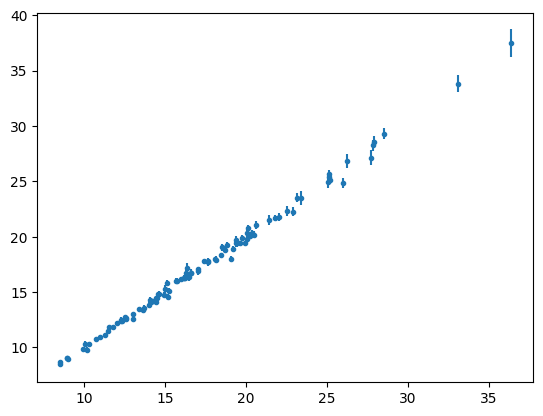

In [ ]:
from torch.distributions import MultivariateNormal


def monte_carlo_kl_qp(mu_q, logvar_q, mu_p, logvar_p, n=1000):
    q = MultivariateNormal(loc=mu_q, covariance_matrix=torch.diag(torch.exp(logvar_q)))
    p = MultivariateNormal(loc=mu_p, covariance_matrix=torch.diag(torch.exp(logvar_p)))
    samples = q.sample((n,))
    log_q = q.log_prob(samples)
    log_p = p.log_prob(samples)
    est_kl = (log_q - log_p).mean()
    mcse_kl = torch.std(log_q - log_p) / np.sqrt(n)
    return est_kl, mcse_kl
mu_p = torch.zeros(LATENT_DIM)
logvar_p = torch.zeros(LATENT_DIM)
recog = RecognitionModel(LATENT_DIM)

ana = []
kl_mc, kl_mcse = [], []
for _ in range(100):
  mu_q = torch.randn(LATENT_DIM)
  logvar_q = torch.randn(LATENT_DIM)
  ana.append(recog.kl(mu_q, logvar_q))
  tmp1, tmp2 = monte_carlo_kl_qp(mu_q, logvar_q, mu_p, logvar_p, n=1000)
  kl_mc.append(tmp1)
  kl_mcse.append(tmp2)
import matplotlib.pyplot as plt
plt.errorbar(x=ana, y=kl_mc, yerr=kl_mcse, linestyle='none', marker='.')

In [ ]:

def train_model(train_loader, model, optimizer, device, num_epochs=NUM_EPOCHS, beta=BETA):
    model.to(device)
    model.train()
    losses = []
    steps = 0

    for epoch in tqdm(range(num_epochs), desc='Epochs'):
        total_loss = 0

        for batch_idx, (data, _) in enumerate(train_loader):
            steps += 1
            data = data.view(-1, 784).to(device)

            optimizer.zero_grad()
            loss, _ = model.loss(data)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

    plt.figure()
    plt.title('IWAE Loss Graph')
    plt.xlabel('steps')
    plt.ylabel('loss')
    plt.plot(range(steps), losses, color = 'blue')
    plt.show()
    plt.close()

    return model


def test_VAE(test_loader, vae, device, num_examples = 3):
    vae = vae.to("cpu")
    vae.eval()
    images = []
    label = 0
    images = []
    label = 0
    for x, y in dataset:
        if label == 10:
            break

        if y == label:
            images.append(x)
            label += 1

    for d in range(10):
        with torch.no_grad():
            mu, sigma = vae.encoder(images[d].view(1, 784))

            for i in range(num_examples):
                z = vae.reparameterize(mu, sigma)
                output  = vae.decoder(z)
                output = output.view(-1, 1, 28, 28)
                save_image(output, f"output/generated_{d}_ex_{i}.png")



Epochs: 100%|██████████| 10/10 [02:48<00:00, 16.82s/it]


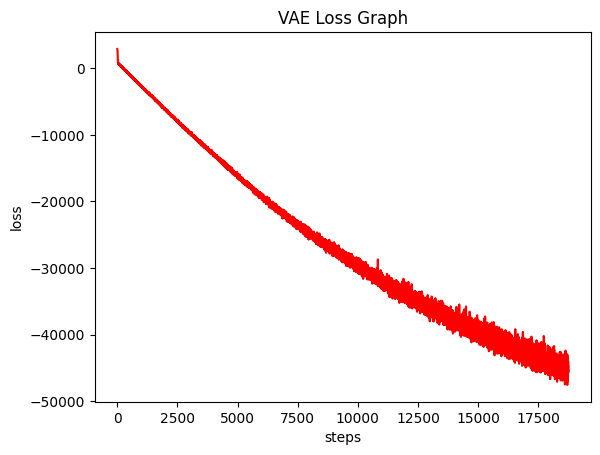

In [ ]:
dataset = datasets.MNIST(root='dataset/', train=True, transform = transforms.Compose([
    transforms.ToTensor()
    # transforms.Normalize((0.5,), (0.5,))
]), download=True)
train_loader = DataLoader(dataset=dataset, batch_size= BATCH_SIZE, shuffle=True)

vae = VAE(RecognitionModel(LATENT_DIM), DensityNet(LATENT_DIM))
vae.parameters()  # [e.fc1, e.fc21, e.fc22, d.fc3, d.fc4, d.logvar]

optim_vae = torch.optim.Adam(vae.parameters(), lr=LR_RATE)

vae = train_model(train_loader, vae, optim_vae, DEVICE, NUM_EPOCHS, BETA)




Epochs: 100%|██████████| 10/10 [03:13<00:00, 19.31s/it]


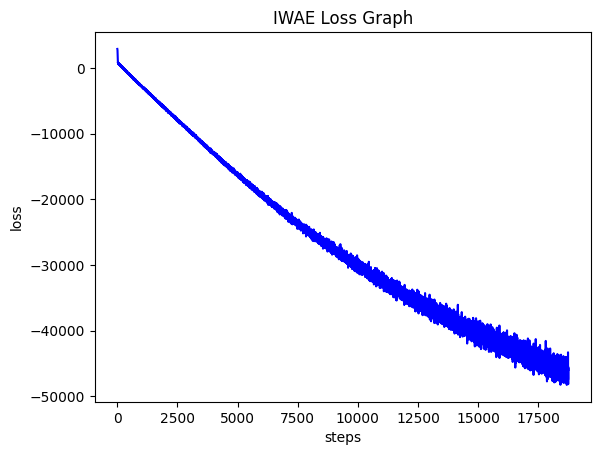

In [ ]:
iwae = IWAE(RecognitionModel(LATENT_DIM), DensityNet(LATENT_DIM))
iwae.parameters()

optim_iwae = torch.optim.Adam(iwae.parameters(), lr=LR_RATE)

iwae = train_model(train_loader, iwae, optim_iwae, DEVICE, NUM_EPOCHS, BETA)

Min/max values of x are tensor(2.9173e-21) tensor(0.9994)


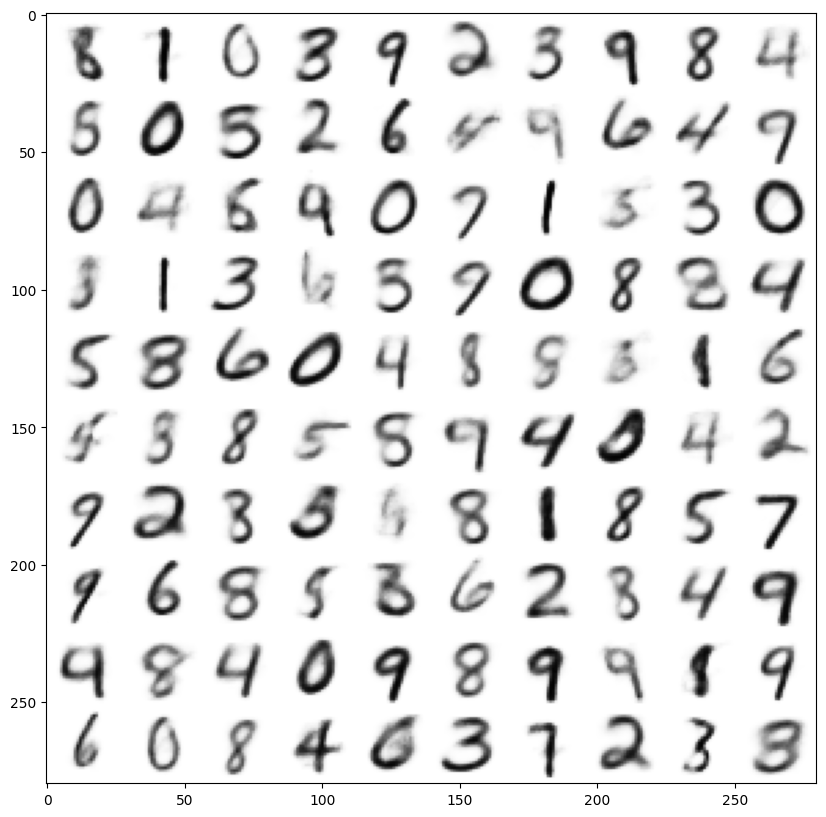

In [ ]:
vae.cpu()
vae.eval()

# quick and dirty ancestral sampling...
# Step 1: draw some z ~ p(z)
n_samples = 100
z = torch.randn((n_samples, Z_DIM))
# Step2 : sample x ~ p(x|z)
# Step 2a: get mu_x | z
with torch.no_grad():
  mu_x = vae.decoder(z)
  # Step 2b: sample x ~ normal(mu_x, logvar_x)
  # IGNORED
  eps = torch.randn(n_samples, INPUT_DIM)
  std_x = torch.exp(vae.decoder.logvar_x / 2)
  x = mu_x #+ std_x * eps

print(f"Min/max values of x are", x.min(), x.max())

grid_of_generated_xs = x.reshape(10, 10, 28, 28).permute(0, 2, 1, 3).reshape(280, 280)
plt.figure(figsize=(10, 10))
plt.imshow(grid_of_generated_xs, cmap='Greys')
plt.show()

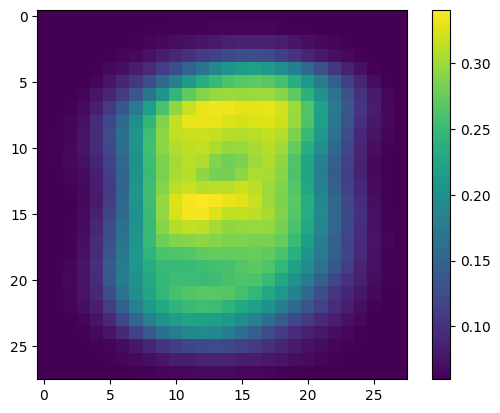

In [ ]:
plt.imshow(std_x.reshape(28,28))
plt.colorbar()

Min/max values of x are tensor(1.8434e-30) tensor(0.9995)


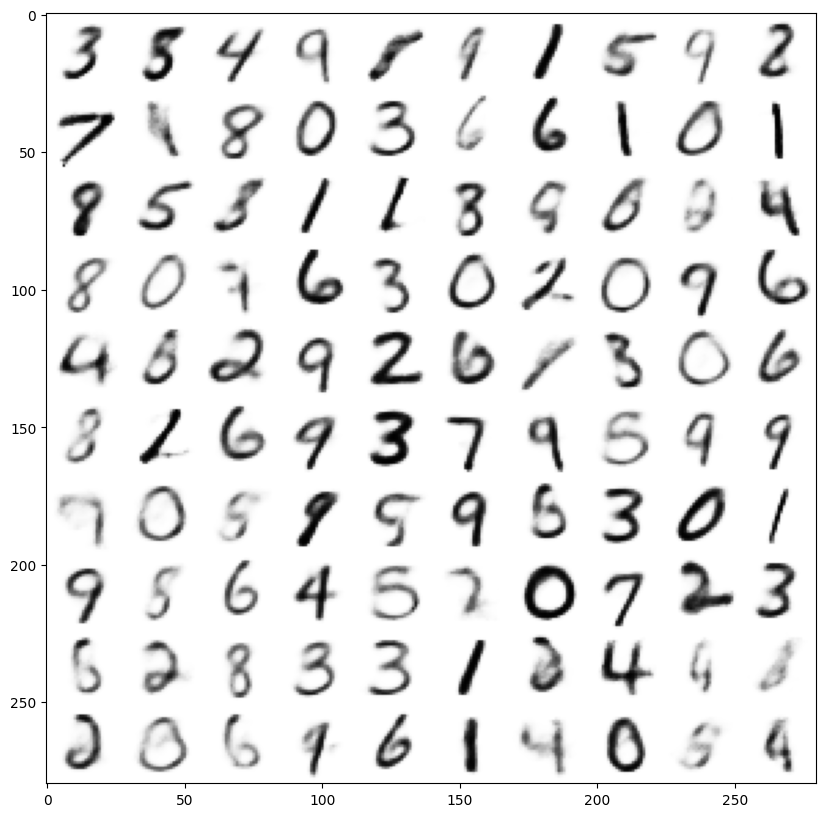

In [ ]:
iwae.cpu()
iwae.eval()

# quick and dirty ancestral sampling...
# Step 1: draw some z ~ p(z)
n_samples = 100
z = torch.randn((n_samples, Z_DIM))
# Step2 : sample x ~ p(x|z)
# Step 2a: get mu_x | z
with torch.no_grad():
  mu_x = iwae.decoder(z)
  # Step 2b: sample x ~ normal(mu_x, logvar_x)
  # IGNORED
  eps = torch.randn(n_samples, INPUT_DIM)
  std_x = torch.exp(iwae.decoder.logvar_x / 2)
  x = mu_x #+ std_x * eps

print(f"Min/max values of x are", x.min(), x.max())

grid_of_generated_xs = x.reshape(10, 10, 28, 28).permute(0, 2, 1, 3).reshape(280, 280)
plt.figure(figsize=(10, 10))
plt.imshow(grid_of_generated_xs, cmap='Greys')
plt.show()

In [ ]:
test_VAE(dataset, vae, DEVICE, num_examples=2)